In [1]:
import awkward as ak
import matplotlib.pyplot as plt
import os, sys
import subprocess
import json
import uproot
from coffea.nanoevents import NanoEventsFactory, ScoutingNanoAODSchema
from coffea.lookup_tools.lookup_base import lookup_base
import numpy as np
from coffea import processor, util
from hist import Hist
import hist
from coffea.analysis_tools import Weights, PackedSelection
from collections import defaultdict
import mplhep
plt.style.use(mplhep.style.CMS)

In [40]:
class Processor(processor.ProcessorABC):
    def __init__(self, wp_btag=0):
        self._wp_btag = wp_btag
        
    @property
    def accumulator(self):
        return {
            "sumw": defaultdict(float),
            "cutflow": defaultdict(int),
            "templates": (
                            Hist.new.StrCategory(
                                [], name="dataset", label="Dataset", growth=True
                            ).StrCategory(
                                [], name="region", label="Region", growth=True
                            ).StrCategory(
                                [], name="cat", label="Category", growth=True
                            ).Reg(
                                50, 200, 700, name="pt", label=r"$p_T$"
                            ).Reg(
                                50, 40, 220, name="msoftdrop", label=r"msoftdrop"
                            ).Reg(
                                50, 40, 220, name="mreg", label=r"mreg"
                            ).Reg(
                                50, 0, 1, name="ddb", label=r"ddb"
                            ).Double()
                        ),
        }
           
        
    def process(self, events):
        
        output = self.accumulator
        dataset = events.metadata['dataset']
        
        isRealData = not hasattr(events, "genWeight")
        isQCDMC = 'QCD' in dataset
        
        selection = PackedSelection()
        
        if not isRealData:
            output['sumw'][dataset] += ak.sum(events.genWeight)
            
        if len(events) == 0:
            return output
        
        fatjets = events.ScoutingFatJet
        fatjets["pn_Hbb"] = ak.where((fatjets.particleNet_prob_Hbb + fatjets.particleNet_prob_QCD) == 0, 0, (fatjets.particleNet_prob_Hbb / (fatjets.particleNet_prob_Hbb + fatjets.particleNet_prob_QCD)))
        jets = events.ScoutingJet
        jets["pn_b"] = ak.where((jets.particleNet_prob_b + jets.particleNet_prob_g) == 0, 0, (jets.particleNet_prob_b / (jets.particleNet_prob_b + jets.particleNet_prob_g)))
        
        # trigger
        selection.add("trigger", events.HLT["Mu50"])
        
        # require MET
        met = events.ScoutingMET
        selection.add('met', met.pt > 50)
        
        # require at least one good muon
        goodmuon = (
            (events.ScoutingMuon.pt > 55)
            & (abs(events.ScoutingMuon.eta) < 2.4)
            & (abs(events.ScoutingMuon.trk_dxy) < 0.2)
            #& (abs(events.ScoutingMuon.trk_dz) < 0.5)
            #& (events.ScoutingMuon["type"] == 2)
            & (events.ScoutingMuon.normchi2 < 10)
            & (events.ScoutingMuon.nValidRecoMuonHits > 0)
            & (events.ScoutingMuon.nRecoMuonMatchedStations > 1)
            & (events.ScoutingMuon.nValidPixelHits > 0)
            & (events.ScoutingMuon.nTrackerLayersWithMeasurement > 5)            
        )
        
        nmuons = ak.sum(goodmuon, axis=1)
        selection.add('onemuon', (nmuons > 0))
        
        # require good leptonic W 
        leadingmuon = ak.firsts(events.ScoutingMuon[goodmuon])
        leptonicW = met + leadingmuon
        selection.add('leptonicW', leptonicW.pt > 150)
        
        # require at least one b-jet in the same hemisphere of the leading muon
        dphi = abs(jets.delta_phi(leadingmuon))
        jetsamehemisp = jets[dphi < 2]
        bjets = (jetsamehemisp.pn_b > self._wp_btag)
        nbjets = ak.sum(bjets, axis=1)
        selection.add('onebjet', (nbjets > 0))

        # require fatjet away from the leading muon
        dphi = abs(fatjets.delta_phi(leadingmuon))
        is_away = (dphi > 2)
        nfatjets = ak.sum(is_away, axis=1)
        selection.add('onefatjet', (nfatjets > 0))
        
        proxy = ak.firsts(fatjets[(is_away) & (fatjets.pt > 200)])
            
        regions = {
            'all': ['trigger','met','onemuon','leptonicW','onebjet','onefatjet'],
            'noselection': [],
        }
        
        def normalize(val, cut):
            if cut is None:
                ar = ak.to_numpy(ak.fill_none(val, np.nan))
                return ar
            else:
                ar = ak.to_numpy(ak.fill_none(val[cut], np.nan))
                return ar
            
        def fill(region, jet, _cut=None):
            selections = regions[region]
            cut = selection.all(*selections)
            
            output['templates'].fill(
                dataset=dataset,
                region=region,
                cat=normalize(jet.cat, cut),
                pt=normalize(jet.pt, cut),
                msoftdrop=normalize(jet.msoftdrop, cut),
                mreg=normalize(jet.particleNet_mass, cut),
                ddb=normalize(jet.pn_Hbb, cut),
            )
            
        # get top
        top = events.GenPart[
            (abs(events.GenPart.pdgId) == 6)
            & (events.GenPart.hasFlags(['fromHardProcess', 'isLastCopy']))
        ]
        
        # get W
        w = events.GenPart[
            (abs(events.GenPart.pdgId) == 24)
            & (events.GenPart.hasFlags(['fromHardProcess', 'isLastCopy']))
        ]

        # check if W is hadronic
        w_is_had = ak.any(
            (abs(w.distinctChildren.pdgId) < 7)
            & (w.distinctChildren.hasFlags(['isLastCopy']))
        , axis=2)
        had_w = w[w_is_had]
        
        # get W from top
        w_top = top.distinctChildren[
            (abs(top.distinctChildren.pdgId) == 24)
            & (top.distinctChildren.hasFlags(['isLastCopy']))
        ]
        w_top = ak.flatten(w_top, axis=2)
        
        # check if W from top is hadronic
        w_top_is_had = ak.any(
            (abs(w_top.distinctChildren.pdgId) < 7)
            & (w_top.distinctChildren.hasFlags(['isLastCopy']))
        , axis=2)
        
        # get top with hadronic W as child
        had_top = w_top[w_top_is_had].distinctParent
        
        # get dR between hadronic top and fatjet
        near_top, near_top_dr = proxy.nearest(had_top, axis=None, threshold=0.8, return_metric=True)
        near_top_dr = ak.to_numpy(ak.fill_none(near_top_dr, 99))
        
        # get dR between hadronic W and fatjet
        near_W, near_W_dr = proxy.nearest(had_w, axis=None, threshold=0.8, return_metric=True)
        near_W_dr = ak.to_numpy(ak.fill_none(near_W_dr, 99))

        q_W = near_W.distinctChildren
        q_W_dr = proxy.delta_r(q_W)
        index_descend_q_W = ak.argsort(q_W_dr, axis=1) #ascending=False
        q_W_dr_descend = q_W_dr[index_descend_q_W]
        
        # get b from near top
        b_near_top = near_top.distinctChildren[abs(near_top.distinctChildren.pdgId) == 5]
        b_near_top_matched, b_near_top_dr = proxy.nearest(b_near_top, axis=None, threshold=0.8, return_metric=True)
        b_near_top_dr = ak.to_numpy(ak.fill_none(b_near_top_dr, 99))

        # get W from near top
        W_near_top = near_top.distinctChildren[(
            (abs(near_top.distinctChildren.pdgId) == 24)
            & (ak.any(abs(near_top.distinctChildren.distinctChildren.pdgId) < 7))
        )]
        
        # get quarks from W from near top
        q_W_near_top = ak.flatten(W_near_top.distinctChildren, axis=2)
        q_W_near_top_dr = proxy.delta_r(q_W_near_top)
        
        # get distance from quarks and fatjet
        index_ascend = ak.argsort(q_W_near_top_dr, axis=1)
        index_descend = ak.argsort(q_W_near_top_dr, ascending=False, axis=1)
        q_W_near_top_ascend = q_W_near_top[index_ascend]
        q_W_near_top_descend = q_W_near_top[index_descend]
        q_W_near_top_dr_ascend = q_W_near_top_dr[index_ascend]
        q_W_near_top_dr_descend = q_W_near_top_dr[index_descend]

        proxy["dr_T"] = near_top_dr
        proxy["dr_T_b"] = b_near_top_dr
        proxy["dr_T_Wq_max"] = ak.fill_none(ak.firsts(q_W_near_top_dr_descend), 99)
        proxy["dr_T_Wq_min"] = ak.fill_none(ak.firsts(q_W_near_top_dr_ascend), 99)
        proxy["dr_T_Wq_max_pdgId"] = ak.fill_none(ak.firsts(q_W_near_top_descend).pdgId, 99)
        proxy["dr_T_Wq_min_pdgId"] = ak.fill_none(ak.firsts(q_W_near_top_ascend).pdgId, 99)
        proxy["dr_W_daus"] = ak.fill_none(ak.firsts(q_W_dr_descend), 99)
        
        top_matched = (proxy["dr_T_b"] < 0.8) & (proxy["dr_T_Wq_max"] < 0.8)
        w_matched = (((proxy["dr_T_Wq_max_pdgId"] == 99) & (proxy["dr_W_daus"] < 0.8)) | ((proxy["dr_T_Wq_max_pdgId"] != 99) & (proxy["dr_T_b"] >= 0.8) & (proxy["dr_T_Wq_max"] < 0.8)))
        non_matched = (~top_matched) & (~w_matched)
        
        cat = np.repeat("ERROR", len(proxy.pt))
        cat = ["top_matched" if t else c for c, t in zip(cat, top_matched.to_numpy())]
        cat = ["w_matched" if w else c for c, w in zip(cat, w_matched.to_numpy())]
        cat = ["non_matched" if n else c for c, n in zip(cat, non_matched.to_numpy())]
        proxy["cat"] = cat
            
        for region, cuts in regions.items():
            fill(region, proxy)
            
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [29]:
fileset = {
    "TTtoLNu2Q" : [
        "root://eosuser.cern.ch//eos/user/a/adlintul/TTtoLNu2Q_TuneCP5_13p6TeV_powheg-pythia8/Run3Summer22/230131_071621/0000/nanoaod_1.root"
    ],
}

p = Processor()

futures_run = processor.Runner(
    executor = processor.FuturesExecutor(compression=None, workers=2),
    schema = ScoutingNanoAODSchema,
    maxchunks = 10,
)

out = futures_run(
    fileset,
    treename="Events",
    processor_instance=p
)

Output()

/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


In [41]:
import json

fileset = {}

with open("files_short.json") as fin:
    fileset = json.load(fin)

In [42]:
from distributed import Client
from lpcjobqueue import LPCCondorCluster

from dask.distributed import performance_report
from dask_jobqueue import HTCondorCluster, SLURMCluster

env_extra = [
    f"export PYTHONPATH=$PYTHONPATH:{os.getcwd()}",
]

cluster = LPCCondorCluster(
    ship_env=True,
    memory="12GB",
)

cluster.adapt(minimum=1, maximum=100)
client = Client(cluster)

print("Waiting for at least one worker...")
client.wait_for_workers(1)

uproot.open.defaults["xrootd_handler"] = uproot.source.xrootd.MultithreadedXRootDSource

out = processor.run_uproot_job(
            fileset,
            "Events",
            processor_instance=Processor(),
            executor=processor.dask_executor,
            executor_args={
                "schema": ScoutingNanoAODSchema,
                #"savemetrics": True,
                "retries": 3,
                "client": client,
                'skipbadfiles':True,
            },
            chunksize=10000,
            #maxchunks=args.max,
        )

For details, see https://htcondor-wiki.cs.wisc.edu/index.cgi/wiki?p=PlanToReplaceGridCommunityToolkit


Waiting for at least one worker...


For details, see https://htcondor-wiki.cs.wisc.edu/index.cgi/wiki?p=PlanToReplaceGridCommunityToolkit


[#########                               ] | 22% Completed |  6min 16.6ss

KeyboardInterrupt: 

In [5]:
outfile = "TTtoLNu2Q.coffea"
util.save(out, outfile)

out

{'sumw': defaultdict(float, {'TTtoLNu2Q': 18994655257.6875}),
 'cutflow': defaultdict(int, {}),
 'templates': Hist(
   StrCategory(['TTtoLNu2Q'], growth=True, name='dataset', label='Dataset'),
   StrCategory(['all', 'noselection'], growth=True, name='region', label='Region'),
   StrCategory(['non_matched', 'nan', 'w_matched', 'top_matched'], growth=True, name='cat', label='Category'),
   Regular(50, 200, 700, name='pt', label='$p_T$'),
   Regular(50, 60, 220, name='msoftdrop'),
   Regular(50, 60, 220, name='mreg'),
   Regular(50, 0, 1, name='ddb'),
   storage=Double()) # Sum: 172861.0 (58909157.0 with flow)}

In [35]:
out = util.load("TTtoLNu2Q.coffea")

out

{'sumw': defaultdict(float, {'TTtoLNu2Q': 18994655257.6875}),
 'cutflow': defaultdict(int, {}),
 'templates': Hist(
   StrCategory(['TTtoLNu2Q'], growth=True, name='dataset', label='Dataset'),
   StrCategory(['all', 'noselection'], growth=True, name='region', label='Region'),
   StrCategory(['non_matched', 'nan', 'w_matched', 'top_matched'], growth=True, name='cat', label='Category'),
   Regular(50, 200, 700, name='pt', label='$p_T$'),
   Regular(50, 60, 220, name='msoftdrop'),
   Regular(50, 60, 220, name='mreg'),
   Regular(50, 0, 1, name='ddb'),
   storage=Double()) # Sum: 172861.0 (58909157.0 with flow)}

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

labels = {
    "non_matched" : "Non matched",
    "w_matched" : "W matched",
    "top_matched" : "Top matched",
}

row = 0
column = 0
for i, var in enumerate(['pt', 'mass','mreg','ddb']):
    
    if i == 2:
        row = 0
        column = 1

    for cat in ["non_matched", "w_matched", "top_matched"]:
        
        h = out['templates'].project('region','cat', var)[hist.loc('all'), hist.loc(cat), :]

        mplhep.histplot(h, label=labels[cat], ax=axs[row, column], stack=True)
        
    axs[row, column].set_yscale('log')
    row += 1
        
axs[0,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
h = out['templates'].project('region','cat', 'ddb', var)[hist.loc('all'), hist.loc("top_matched"), :, :]

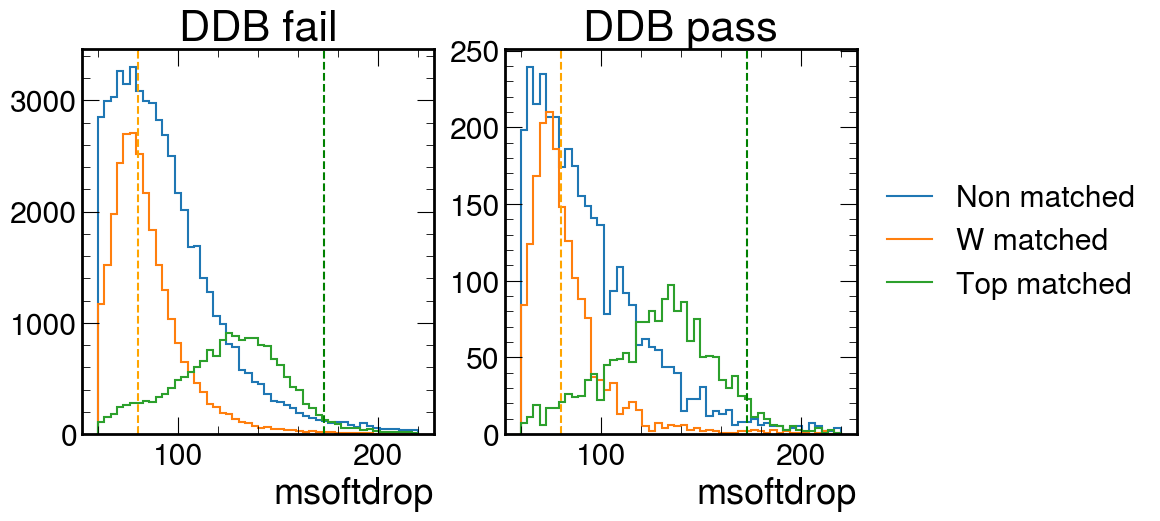

In [38]:
labels = {
    "non_matched" : "Non matched",
    "w_matched" : "W matched",
    "top_matched" : "Top matched",
}

for var in ['msoftdrop']: #,'mreg', 'pt']:
    
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    
    for cat in ["non_matched", "w_matched", "top_matched"]:
        
        h = out['templates'].project('region','cat', 'ddb', var)[hist.loc('noselection'), hist.loc(cat), :, :]

        mplhep.histplot(h[{"ddb": slice(0j, 0.4j, sum)}], stack=True, label=labels[cat], ax=axs[0])
        mplhep.histplot(h[{"ddb": slice(0.4j, 1j, sum)}], stack=True, label=labels[cat], ax=axs[1])
        
    #axs[0].set_yscale('log') 
    #axs[1].set_yscale('log') 
    axs[0].set_title("DDB fail")
    axs[1].set_title("DDB pass")
    axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    if var == "mass" or var == "msoftdrop":
        axs[0].axvline(80, color='orange',ls='--')
        axs[0].axvline(173, color='green',ls='--')
        axs[1].axvline(80, color='orange',ls='--')
        axs[1].axvline(173, color='green',ls='--')

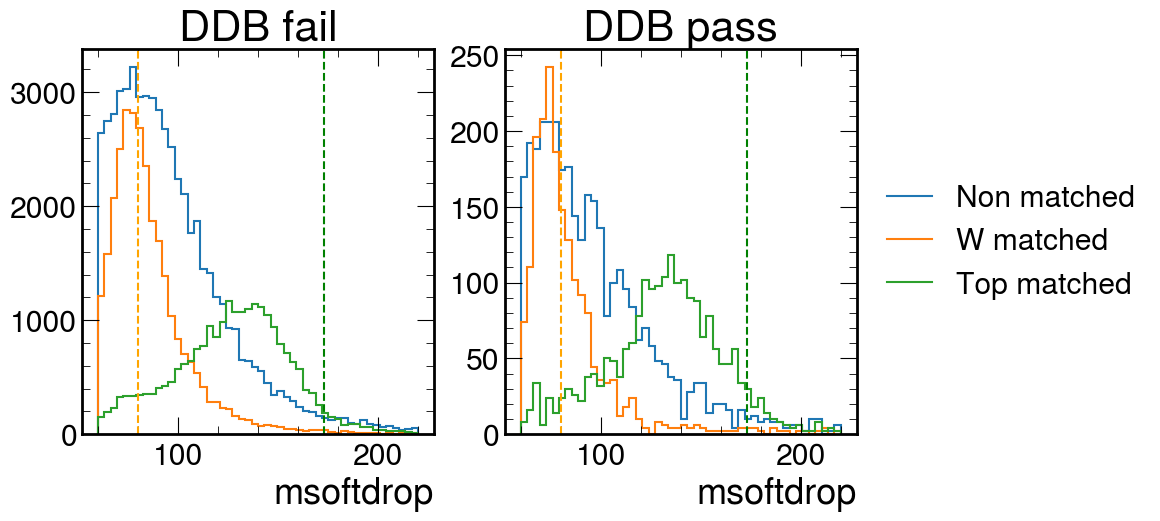

In [39]:
labels = {
    "non_matched" : "Non matched",
    "w_matched" : "W matched",
    "top_matched" : "Top matched",
}

for var in ['msoftdrop']: #,'mreg', 'pt']:
    
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    
    for cat in ["non_matched", "w_matched", "top_matched"]:
        
        h = out['templates'].project('region','cat', 'ddb', var)[hist.loc('all'), hist.loc(cat), :, :]

        mplhep.histplot(h[{"ddb": slice(0j, 0.4j, sum)}], stack=True, label=labels[cat], ax=axs[0])
        mplhep.histplot(h[{"ddb": slice(0.4j, 1j, sum)}], stack=True, label=labels[cat], ax=axs[1])
        
    #axs[0].set_yscale('log') 
    #axs[1].set_yscale('log') 
    axs[0].set_title("DDB fail")
    axs[1].set_title("DDB pass")
    axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    if var == "mass" or var == "msoftdrop":
        axs[0].axvline(80, color='orange',ls='--')
        axs[0].axvline(173, color='green',ls='--')
        axs[1].axvline(80, color='orange',ls='--')
        axs[1].axvline(173, color='green',ls='--')

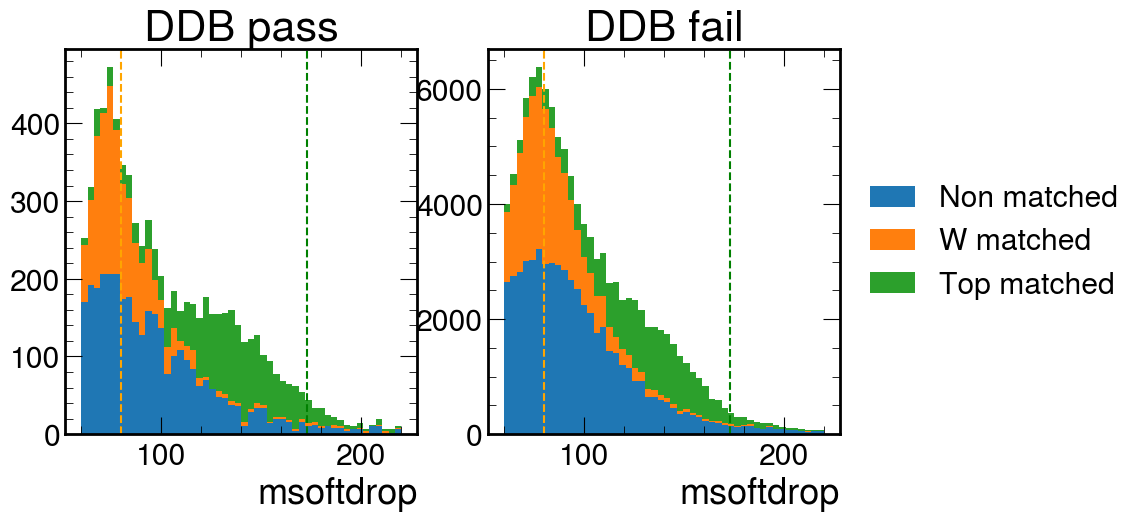

In [12]:
labels = {
    "non_matched" : "Non matched",
    "w_matched" : "W matched",
    "top_matched" : "Top matched",
}

for var in ['msoftdrop']:
    
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    
    var = "msoftdrop"
        
    h_pass = out['templates'].project('region','cat', 'ddb', var)[hist.loc('all'), :, slice(0.4j, 1j, sum), :]
    h_fail = out['templates'].project('region','cat', 'ddb', var)[hist.loc('all'), :, slice(0j, 0.4j, sum), :]

    mplhep.histplot([h_pass[hist.loc("non_matched"), :], h_pass[hist.loc("w_matched"), :], h_pass[hist.loc("top_matched"), :]], stack=True, label=["Non matched", "W matched", "Top matched"], ax=axs[0], histtype="fill")
    mplhep.histplot([h_fail[hist.loc("non_matched"), :], h_fail[hist.loc("w_matched"), :], h_fail[hist.loc("top_matched"), :]], stack=True, label=["Non matched", "W matched", "Top matched"], ax=axs[1], histtype="fill")
            
    #axs[0].set_yscale('log') 
    #axs[1].set_yscale('log') 
    axs[0].set_title("DDB pass")
    axs[1].set_title("DDB fail")
    axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    axs[0].axvline(80, color='orange',ls='--')
    axs[0].axvline(173, color='green',ls='--')
    axs[1].axvline(80, color='orange',ls='--')
    axs[1].axvline(173, color='green',ls='--')

In [ ]:
fileset = {
    "TTtoLNu2Q" : [
        "root://eosuser.cern.ch//eos/user/a/adlintul/TTtoLNu2Q_TuneCP5_13p6TeV_powheg-pythia8/Run3Summer22/230131_071621/0000/nanoaod_1.root"
    ],
}

events = NanoEventsFactory.from_root(
    fileset['TTtoLNu2Q'][0],
    schemaclass=ScoutingNanoAODSchema
).events()

In [ ]:
fatjet = ak.firsts(events.ScoutingFatJet)

# get top
top = events.GenPart[
    (abs(events.GenPart.pdgId) == 6)
    & (events.GenPart.hasFlags(['fromHardProcess', 'isLastCopy']))
]

# get W
w = events.GenPart[
    (abs(events.GenPart.pdgId) == 24)
    & (events.GenPart.hasFlags(['fromHardProcess', 'isLastCopy']))
]

# check if W is hadronic
w_is_had = ak.any(
    (abs(w.distinctChildren.pdgId) < 7)
    & (w.distinctChildren.hasFlags(['isLastCopy']))
, axis=2)
had_w = w[w_is_had]

# get W from top
w_top = top.distinctChildren[
    (abs(top.distinctChildren.pdgId) == 24)
    & (top.distinctChildren.hasFlags(['isLastCopy']))
]
w_top = ak.flatten(w_top, axis=2)

# check if W is hadronic
w_top_is_had = ak.any(
    (abs(w_top.distinctChildren.pdgId) < 7)
    & (w_top.distinctChildren.hasFlags(['isLastCopy']))
, axis=2)

# get top with hadronic W as child
had_top = w_top[w_top_is_had].distinctParent
#for t in had_top:
#    print(t)

# get dR between hadronic top and fatjet
near_top, near_top_dr = fatjet.nearest(had_top, axis=None, threshold=0.8, return_metric=True)
near_top_dr = ak.to_numpy(ak.fill_none(near_top_dr, 99))
#for top, dr in zip(near_top, near_top_dr):
#    print(dr, top)
#for p, nt in zip(proxy, near_top):
#    print(p, nt)

# get dR between hadronic w and fatjet
near_W, near_W_dr = fatjet.nearest(had_w, axis=None, threshold=0.8, return_metric=True)
near_W_dr = ak.to_numpy(ak.fill_none(near_w_dr, 99))

q_W = near_W.distinctChildren
q_W_dr = fatjet.delta_r(q_W)
index_descend_q_W = ak.argsort(q_W_dr, ascending=False, axis=1)
q_W_dr_descend = q_W_dr[index_descend_q_W]

In [ ]:
# get b from near top
b_near_top = near_top.distinctChildren[abs(near_top.distinctChildren.pdgId) == 5]
b_near_top_matched, b_near_top_dr = fatjet.nearest(b_near_top, axis=None, threshold=0.8, return_metric=True)
b_near_top_dr = ak.to_numpy(ak.fill_none(b_near_top_dr, 99))
#for b, dr in zip(b_near_top_matched, b_near_top_dr):
#    print(dr, b)

# get W from near top
W_near_top = near_top.distinctChildren[(
    (abs(near_top.distinctChildren.pdgId) == 24)
    & (ak.any(abs(near_top.distinctChildren.distinctChildren.pdgId) < 7))
)]

# get quarks from W from near top
q_W_near_top = ak.flatten(W_near_top.distinctChildren, axis=2)
q_W_near_top_dr = fatjet.delta_r(q_W_near_top)

# get distance from quarks and fatjet
index_ascend = ak.argsort(q_W_near_top_dr, axis=1)
index_descend = ak.argsort(q_W_near_top_dr, ascending=False, axis=1)
q_W_near_top_ascend = q_W_near_top[index_ascend]
q_W_near_top_descend = q_W_near_top[index_descend]
q_W_near_top_dr_ascend = q_W_near_top_dr[index_ascend]
q_W_near_top_dr_descend = q_W_near_top_dr[index_descend]

fatjet["dr_T"] = near_top_dr
fatjet["dr_T_b"] = b_near_top_dr
fatjet["dr_T_Wq_max"] = ak.fill_none(ak.firsts(q_W_near_top_dr_descend), 99)
fatjet["dr_T_Wq_min"] = ak.fill_none(ak.firsts(q_W_near_top_dr_ascend), 99)
fatjet["dr_T_Wq_max_pdgId"] = ak.fill_none(ak.firsts(q_W_near_top_descend).pdgId, 99)
fatjet["dr_T_Wq_min_pdgId"] = ak.fill_none(ak.firsts(q_W_near_top_ascend).pdgId, 99)
fatjet["dr_W_daus"] = ak.fill_none(ak.firsts(q_W_dr_descend), 99)

In [ ]:
top_matched = (fatjet["dr_T_b"] < 0.8) & (fatjet["dr_T_Wq_max"] < 0.8)
w_matched = (((fatjet["dr_T_Wq_max_pdgId"] == 99) & (fatjet["dr_W_daus"] < 0.8)) | ((fatjet["dr_T_Wq_max_pdgId"] != 99) & (fatjet["dr_T_b"] >= 0.8) & (fatjet["dr_T_Wq_max"] < 0.8)))
non_matched = (~top_matched) & (~w_matched)

cat = np.repeat("ERROR", len(fatjet.pt))
cat = ["top_matched" if t else c for c, t in zip(cat, top_matched.to_numpy())]
cat = ["w_matched" if w else c for c, w in zip(cat, w_matched.to_numpy())]
cat = ["non_matched" if n else c for c, n in zip(cat, non_matched.to_numpy())]
fatjet["cat"] = cat

In [ ]:
fatjet

In [ ]:
q_W

In [ ]:
fatjet.delta_r(q_W)

In [ ]:
fatjet.delta_r(q_W_near_top)